<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# WebCam Image Classification Quickstart Notebook

<br>

Image classification is a classical problem in computer vision that determining whether or not the image data contains some specific object, feature, or activity. It is regarded as a mature research area
and currently the best models are based on [convolutional neural networks (CNNs)](https://en.wikipedia.org/wiki/Convolutional_neural_network). Such models with weights trained on millions of images and hundreds of object classes in [ImageNet dataset](http://www.image-net.org/) are available from major deep neural network frameworks like [CNTK](https://www.microsoft.com/en-us/cognitive-toolkit/features/model-gallery/), [Keras](https://keras.io/applications/), [PyTorch](https://pytorch.org/docs/stable/torchvision/models.html), and [TensorFlow](https://tfhub.dev/s?module-type=image-classification).


This notebook shows a simple example of how to load pretrained image classification mobel and run it on a webcam stream. Here, we use a pretrained [ResNet](https://arxiv.org/abs/1512.03385) model from `torchvision`, PyTorch's vision library package.

> For more details about image classification tasks including transfer-learning (aka fine tuning), please see our [image classification notebook](01_Image_Classification.ipynb).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import io
import logging
import requests
import shutil
import time

import PIL.Image

from fastai.vision import untar_data, URLs

import torch
from torchvision import models, transforms
from torch.autograd import Variable

from ipywebrtc import CameraStream, ImageRecorder
import ipywidgets as widgets


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

print("Torch:", torch.__version__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Torch: 1.0.0
Device: cuda:0


## 1. Load Pretrained Model

We use ResNet18 which is a relatively small and fast model compare to other CNNs models. The [reported error rate](https://pytorch-zh.readthedocs.io/en/latest/torchvision/models.html) of the model on ImageNet is 30.24% for top-1 and 10.92% for top-5<sup>*</sup>.

The pretrained model expects input images normalized in the following way:
* Mini-batches of 3-channel RGB images of shape (3 x 224 x 224)
* The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

The output of the model is the probability distribution of the classes in ImageNet. To convert them into human-readable labels, we utilize the label json file used from [Keras](https://github.com/keras-team/keras/blob/master/keras/applications/imagenet_utils.py).

> \* top-n: *n* labels considered most probable by the mode

In [3]:
IMAGE_SIZE = 224

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    normalize
])

LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
idx2label = {
    int(key): value[1] for (key, value) in requests.get(LABELS_URL).json().items()
}

print("Num labels =", len(idx2label))
print("Examples:", list(idx2label.values())[:5])

Num labels = 1000
Examples: ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']


In [4]:
# Download ResNet18 model pretrained on ImageNet, set evaluation mode and load to GPU (if available)
model = models.resnet18(pretrained=True).eval().to(device)

## 2. Classify Images


### 2.1 Image file
We use a sample image from `COCO_TINY` in `fastai.vision` just because it is a very small size and easy to download by calling a simple function, `untar_data(URLs.COCO_TINY)`.

> Original [COCO dataset](http://cocodataset.org/) is a large-scale object detection, segmentation, and captioning dataset.

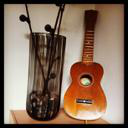

In [5]:
path = untar_data(URLs.COCO_TINY)
im = PIL.Image.open(path/"train"/"000000564902.jpg")
im

In [6]:
start_time = time.time()

im_tensor = preprocess(im).to(device)
im_tensor.unsqueeze_(0)  # Add a batch dimension

out = model(Variable(im_tensor))

end_time = time.time()

print("Top 5:", [idx2label[i] for i in out[0].topk(5)[1][:5].cpu().numpy()])
print("\nTook {} sec.".format(end_time - start_time))


Top 5: ['acoustic_guitar', 'electric_guitar', 'cello', 'violin', 'beaker']

Took 2.8413026332855225 sec.


### 2.2 WebCam Stream

We use `ipywebrtc` to start a webcam and get the video stream to the notebook's widget. For details about `ipywebrtc`, see [this link](https://ipywebrtc.readthedocs.io/en/latest/). 

In [7]:
run_model = True

# Webcam
cam = CameraStream(
    constraints={
        'facing_mode': 'user',
        'audio': False,
        'video': { 'width': IMAGE_SIZE, 'height': IMAGE_SIZE }
    }
)
# Image recorder for taking a snapshot
im_recorder = ImageRecorder(stream=cam)
# Text label widget to show our classification results
labels = [widgets.Label() for _ in range(5)]
labels[0].value = "result classes"

# For every snapshot, we run the pretrained model
def classify_frame(_):
    im = PIL.Image.open(io.BytesIO(im_recorder.image.value))
    im = im.convert('RGB')    
    im_tensor = preprocess(im).to(device)
    im_tensor.unsqueeze_(0)
    out = model(Variable(im_tensor))
    for i, l in enumerate(out[0].topk(5)[1][:5].cpu().numpy()):
        labels[i].value = idx2label[l]
    
    if run_model:
        im_recorder.recording = True
        
im_recorder.image.observe(classify_frame, 'value')

Now, click the **capture button** of the image recorder widget to start classification. Labels show top 5 most probable classes predicted by the model for each image snapshot.

In [8]:
# Show widgets
widgets.HBox([widgets.VBox(labels + [im_recorder]), cam])

<img src="../docs/media/webcam.png" style="width: 400px;"/>

The results maybe not very accurate because the model was not trained on the webcam images. To make the model perform better on new image classification problem, we usually fine-tune the model with new data. Examples about this transfer learning can be found from our [image classification notebook](01_Image_Classification.ipynb).

In [9]:
stop_process = True
widgets.Widget.close_all()

In [ ]:
# Cleanup
shutil.rmtree(path, ignore_errors=True)